# 导入必要的库

我们需要导入一个叫 [captcha](https://github.com/lepture/captcha/) 的库来生成验证码。

我们生成验证码的字符由数字和大写字母组成。

```sh
pip install captcha numpy matplotlib tensorflow-gpu
```

In [1]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
# characters = string.digits + string.ascii_uppercase
characters = string.digits #只有数字

print(characters)

width, height, n_len, n_class = 109, 41, 5, len(characters)

0123456789


# 防止 tensorflow 占用所有显存

In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K


# 定义数据生成器

In [3]:
from tensorflow.keras.utils import Sequence

class CaptchaSequence(Sequence):
    def __init__(self, characters, batch_size, steps, n_len=5, width=109, height=41):
        self.characters = characters
        self.batch_size = batch_size
        self.steps = steps
        self.n_len = n_len
        self.width = width
        self.height = height
        self.n_class = len(characters)
        self.generator = ImageCaptcha(width=width, height=height)
    
    def __len__(self):
        return self.steps

    def __getitem__(self, idx):
        X = np.zeros((self.batch_size, self.height, self.width, 3), dtype=np.float32)
        y = [np.zeros((self.batch_size, self.n_class), dtype=np.uint8) for i in range(self.n_len)]
        for i in range(self.batch_size):
            random_str = ''.join([random.choice(self.characters) for j in range(self.n_len)])
            X[i] = np.array(self.generator.generate_image(random_str)) / 255.0 #NNNNNN
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, self.characters.find(ch)] = 1
        return X, y

# 测试生成器

# 读取数据

(203, 10)
(203, 10)
(203, 41, 109, 3)
65676


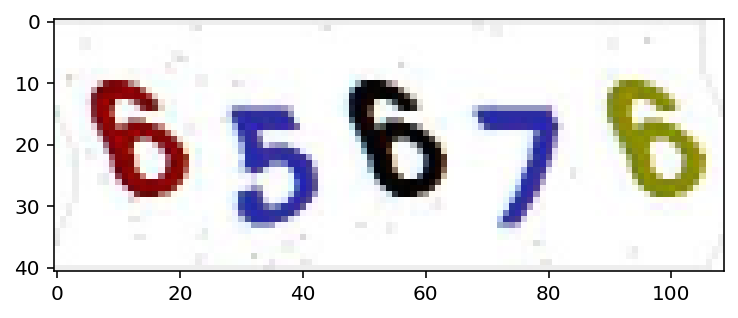

In [4]:
import os
import cv2
import numpy as np
from tensorflow.keras import utils
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])
for root, dirs, files in os.walk('./data'):
    file_list=files
sam=cv2.imread('./data/'+file_list[0])
X=np.zeros((len(file_list),41,109,3))
# y = np.zeros((len(file_list),5,10))
y = [np.zeros((len(file_list), 10), dtype=np.uint8) for i in range(5)]
print(y[0].shape)
for i,name in enumerate(file_list):
    #label
    label=os.path.splitext(name)[0].split('_')[-1]
    y_proto=[k for k in label]
    y_each=utils.to_categorical(y_proto,num_classes=10)
    for index,k in enumerate(y_each):
        y[index][i]=k
    #data
    im=cv2.imread('./data/'+name)
    im=cv2.resize(im,(109,41))
    X[i]=im/255

print(y[0].shape)
print(X.shape)
plt.imshow(X[0])
print(decode(y))

# 定义网络结构

In [179]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i, n_cnn in enumerate([2, 2, 2, 2, 2]):
    for j in range(n_cnn):
        x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]
model = Model(inputs=input_tensor, outputs=x)

In [83]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 41, 109, 3)   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 41, 109, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 41, 109, 32)  128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 41, 109, 32)  0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

# 训练模型

In [180]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import *

train_data = CaptchaSequence(characters, batch_size=128, steps=500)
valid_data = CaptchaSequence(characters, batch_size=128, steps=50)
callbacks = [EarlyStopping(patience=3), CSVLogger('cnn.csv'), ModelCheckpoint('cnn_best.h5', save_best_only=True)]

# model.compile(loss='categorical_crossentropy',
#               optimizer=Adam(1e-3, amsgrad=True), 
#               metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [181]:
model.fit(X,y, epochs=70, validation_split=0.1)
# model.fit_generator(train_data, epochs=100, validation_data=valid_data, workers=4, use_multiprocessing=True,
#                     callbacks=callbacks)

Train on 181 samples, validate on 21 samples
Epoch 1/70
181/181 [==============================] - 4s 24ms/step - loss: 11.9979 - c1_loss: 2.5959 - c2_loss: 2.2051 - c3_loss: 2.1380 - c4_loss: 2.5467 - c5_loss: 2.5123 - c1_acc: 0.1989 - c2_acc: 0.1823 - c3_acc: 0.2431 - c4_acc: 0.2873 - c5_acc: 0.1713 - val_loss: 31.9075 - val_c1_loss: 8.4559 - val_c2_loss: 6.8891 - val_c3_loss: 5.8583 - val_c4_loss: 6.2763 - val_c5_loss: 4.4279 - val_c1_acc: 0.1429 - val_c2_acc: 0.1905 - val_c3_acc: 0.0952 - val_c4_acc: 0.0952 - val_c5_acc: 0.0952
Epoch 2/70
181/181 [==============================] - 0s 2ms/step - loss: 7.3883 - c1_loss: 1.4930 - c2_loss: 1.4959 - c3_loss: 1.2804 - c4_loss: 1.3945 - c5_loss: 1.7244 - c1_acc: 0.4862 - c2_acc: 0.4033 - c3_acc: 0.5470 - c4_acc: 0.5083 - c5_acc: 0.3591 - val_loss: 40.4912 - val_c1_loss: 10.4865 - val_c2_loss: 10.6666 - val_c3_loss: 5.9714 - val_c4_loss: 8.1794 - val_c5_loss: 5.1873 - val_c1_acc: 0.1429 - val_c2_acc: 0.1905 - val_c3_acc: 0.1905 - val_c4_ac

Epoch 18/70
181/181 [==============================] - 0s 2ms/step - loss: 0.0073 - c1_loss: 0.0013 - c2_loss: 0.0014 - c3_loss: 0.0014 - c4_loss: 0.0015 - c5_loss: 0.0017 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.0000 - c5_acc: 1.0000 - val_loss: 15.0220 - val_c1_loss: 3.5601 - val_c2_loss: 3.0003 - val_c3_loss: 2.6940 - val_c4_loss: 3.0995 - val_c5_loss: 2.6681 - val_c1_acc: 0.0952 - val_c2_acc: 0.1429 - val_c3_acc: 0.2381 - val_c4_acc: 0.0476 - val_c5_acc: 0.0952
Epoch 19/70
181/181 [==============================] - 0s 2ms/step - loss: 0.0067 - c1_loss: 0.0013 - c2_loss: 0.0014 - c3_loss: 0.0012 - c4_loss: 0.0013 - c5_loss: 0.0015 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.0000 - c5_acc: 1.0000 - val_loss: 15.2809 - val_c1_loss: 3.6261 - val_c2_loss: 3.0534 - val_c3_loss: 2.7249 - val_c4_loss: 3.1516 - val_c5_loss: 2.7250 - val_c1_acc: 0.0952 - val_c2_acc: 0.1429 - val_c3_acc: 0.2381 - val_c4_acc: 0.0476 - val_c5_acc: 0.0952
Epoch 20/70
181/

181/181 [==============================] - 0s 2ms/step - loss: 0.0023 - c1_loss: 4.1568e-04 - c2_loss: 4.3653e-04 - c3_loss: 4.1158e-04 - c4_loss: 4.3710e-04 - c5_loss: 5.5450e-04 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.0000 - c5_acc: 1.0000 - val_loss: 4.6536 - val_c1_loss: 0.9568 - val_c2_loss: 0.4870 - val_c3_loss: 0.5711 - val_c4_loss: 0.8222 - val_c5_loss: 1.8166 - val_c1_acc: 0.6667 - val_c2_acc: 0.8095 - val_c3_acc: 0.7619 - val_c4_acc: 0.8095 - val_c5_acc: 0.2857
Epoch 51/70
181/181 [==============================] - 0s 2ms/step - loss: 0.0021 - c1_loss: 3.8516e-04 - c2_loss: 4.2074e-04 - c3_loss: 4.0454e-04 - c4_loss: 4.1310e-04 - c5_loss: 4.8844e-04 - c1_acc: 1.0000 - c2_acc: 1.0000 - c3_acc: 1.0000 - c4_acc: 1.0000 - c5_acc: 1.0000 - val_loss: 4.4205 - val_c1_loss: 0.8883 - val_c2_loss: 0.4435 - val_c3_loss: 0.5377 - val_c4_loss: 0.7869 - val_c5_loss: 1.7641 - val_c1_acc: 0.6667 - val_c2_acc: 0.8571 - val_c3_acc: 0.7619 - val_c4_acc: 0.8571 - val_c5_ac

In [184]:
model.save('result.h5')

# 测试模型

In [5]:
model=tf.keras.models.load_model('./result.h5')

[6 8 6 7 6]


(-0.5, 108.5, 40.5, -0.5)

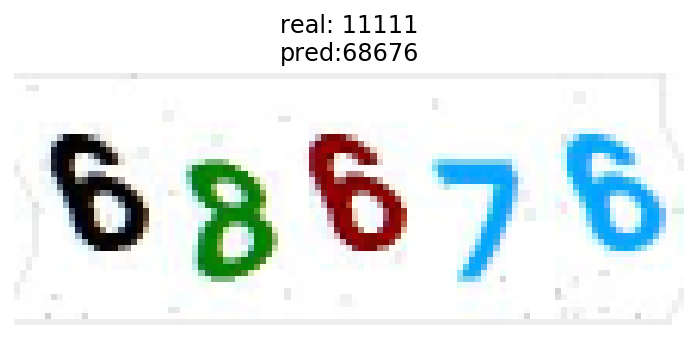

In [7]:
import cv2
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    print(y)
    return ''.join([str(x) for x in y])
# a=cv2.imread('./test/5.jpg')
a=cv2.imread('./data/1.jpg')

a=cv2.resize(a,(109,41))
a=a.reshape((1,41,109,3))
a=a/255
plt.imshow(a[0])
re = model.predict(a)
plt.title('real: %s\npred:%s'%('11111', decode(re)))
# plt.imshow(a[0], cmap='gray')
plt.axis('off')